# Mi año en Spotify

In [ ]:
# Si tienes tus datos que mejor, si no, descarga aquí unos cuantos de los míos
# _ = !wget -O StreamingHistory1.json https://pastebin.com/raw/wq3NZfsK

In [1]:
# Algunos imports
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

Inspirado por [el post de Nerudista en Tacos de datos](https://tacosdedatos.com/dueno-de-mis-datos-spotify) fui a pedirles mi información a Spotify con el fin de hacer unas cuantas gráficas con ella.

Si tu quieres hacer lo mismo, puedes ir a pedirlos en [esta página](https://www.spotify.com/es/account/privacy/), una vez que la solicites, tomará un par de días para que la puedas descargar. 

Pero en fin, entre toda la información que recibirás, habrán algunos archivos que se llaman `StreamingHistoryXX.json`, estos son con los que estaremos trabajando en el resto del post.

## Los datos  

Los archivos dentro de los archivos *json* mencionados anteriormente se ven más o menos así:  


```json
[
  {
    "endTime" : "2019-02-04 17:14",
    "artistName" : "MGMT",
    "trackName" : "Time to Pretend",
    "msPlayed" : 261000
  },
  {
    "endTime" : "2019-02-04 17:18",
    "artistName" : "MGMT",
"..." 
```  

En donde estos son los valores:  

 - `endTime`: Día y hora en los que finalizó la reproducción, en formato UTC (Tiempo Universal Coordinado).
 - `artistName`: Nombre del "creador" de cada elemento reproducido (por ejemplo, el nombre del artista de una canción).
 - `trackName`: Nombre de los elementos reproducidos o vistos (por ejemplo, título de una canción o nombre de un video). 
 - `msPlayed`: significa cuántos milisegundos se reprodujo una canción. 

Para leer estos datos en un DataFrame (que es como los vamos a ocupar más adelante) vamos a hacer uso de esta pequeña función:

In [2]:
from glob import glob
import json
import pandas as pd

def read_history():
    history = []
    for file in sorted(glob("MyData/StreamingHistory*.json")):
        with open(file) as readable:
            history.extend(json.load(readable))
    history = pd.DataFrame(history)
    history["endTime"] = pd.to_datetime(history["endTime"])
    return history

streaming_history = read_history()
streaming_history.head(5)

,endTime,artistName,trackName,msPlayed
0,2020-10-06 20:12:00,Gera MX,Rumores,2693
1,2020-10-07 02:33:00,Gera MX,A Lo Mexicano,118769
2,2020-10-07 02:33:00,Gera MX,Gran Pez,1951
3,2020-10-07 02:36:00,Gera MX,Gran Pez,190375
4,2020-10-07 02:38:00,Gera MX,Gran Pez,147921


## Histograma 

Siempre he sido fan de la forma en la que GitHub presenta las contribuciones que cada desarrollador hace en el sitio, y me parece que los datos obtenidos de Spotify, pero antes vamos a tener que modificar los datos un poco.

Como no nos interesa la hora en que cada canción terminó, primero vamos a deshacernos de la parte temporal de `endTime`:

In [3]:
streaming_history["date"] = streaming_history["endTime"].dt.floor('d')

Luego vamos a obtener un conteo de canciones por día con `groupby`:

In [4]:
by_date = streaming_history.groupby("date")[["trackName"]].count()
by_date = by_date.sort_index()

Para nuestra gráfica, necesitamos también saber a qué día de la semana y qué número de semana corresponde cada fecha, esto lo obtenemos con las propiedades `week` y `weekday`:

In [5]:
by_date["weekday"] = by_date.index.weekday
by_date["week"] = by_date.index.week

/var/folders/5z/s5dw0v0s6bjgn7_r7b4mzkqr0000gp/T/ipykernel_92587/3935525091.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  by_date["week"] = by_date.index.week


Y que al final dejará nuestro DataFrame viéndose así:

In [6]:
by_date.head()

,trackName,weekday,week
date,,,
2020-10-06,1,1,41
2020-10-07,6,2,41
2020-10-09,4,4,41
2020-10-10,13,5,41
2020-10-11,15,6,41


Hasta el momento ya tenemos casi todo, lo que falta es obtener números continuos para la semana, es decir, en el frame de arriba la semana 6 de 2019 debe ser la semana 0, la semana 7 debe ser la semana 1... a mi no se me ocurre otra manera de hacerlo más que con un ciclo `for`:

In [7]:
week = 0
prev_week = by_date.iloc[0]["week"]
continuous_week = np.zeros(len(by_date)).astype(int)
sunday_dates = []
for i, (_, row) in enumerate(by_date.iterrows()):
    if row["week"] != prev_week:
        week += 1
        prev_week = row["week"]
    continuous_week[i] = week
by_date["continuous_week"] = continuous_week 
by_date.head()

,trackName,weekday,week,continuous_week
date,,,,
2020-10-06,1,1,41,0
2020-10-07,6,2,41,0
2020-10-09,4,4,41,0
2020-10-10,13,5,41,0
2020-10-11,15,6,41,0


El siguiente paso es preparar, con NumPy, una matriz de tamaño `días ✕ semanas` en donde cada una de las entradas será la cantidad de canciones que escuchamos en ese día, de esa semana:

In [8]:
songs = np.full((7, continuous_week.max()+1), np.nan)

for index, row in by_date.iterrows():
    songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

Ahora, simplemente podríamos graficar el la matriz `songs`, sin embargo el resultado no es tan agradable:

<AxesSubplot:>

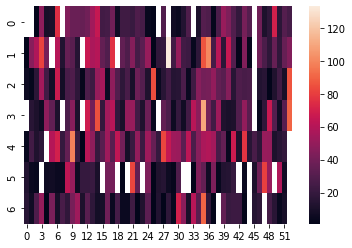

In [9]:
sns.heatmap(songs)

Lo que podemos hacer para mejorarlo requiere de un poco más de código. Lo primero es limpiar un poco las etiquetas de los ejes:

In [10]:
min_date = streaming_history["endTime"].min()
first_monday = min_date - timedelta(min_date.weekday())
mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
x_labels = [calendar.month_abbr[mons[0].month]]
x_labels.extend([
    calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
    for i in range(1, len(mons))])

y_labels = ["Mon", "", "Wed", "", "Fri", "", "Sun"]

Definitivamente las etiquetas del eje de las X son mucho más complicado que las de Y, ya que no son continuas ni fijas, deben ser calculadas de acuerdo a los datos (si queres un poco más de explicación sobre el código, dime en [@io_exception](https://twitter.com/io_exception)).

Después vamos a hacer un poco de *grafimagia* con el tamaño de la gráfica, colores y los ejes. Y ya por último, usaremos el `heatmap` de *seaborn* con algunos cuantos argumentos que explicaré más adelante y desde luego, no olvides que hay que poner las etiquetas que tanto nos costó conseguir:


ValueError: The number of FixedLocator locations (53), usually from a call to set_ticks, does not match the number of ticklabels (52).

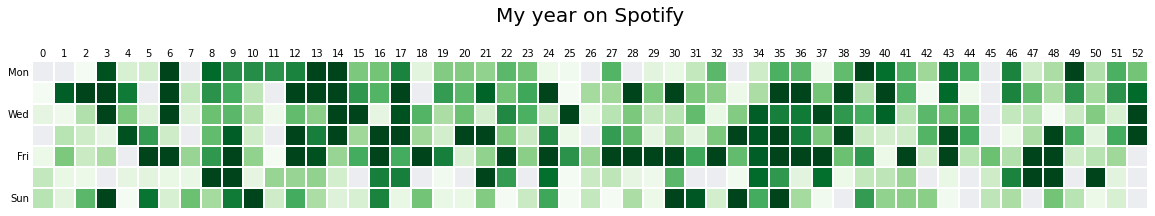

In [11]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot()

ax.set_title("My year on Spotify", fontsize=20,pad=40)
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both',length=0)
ax.set_facecolor("#ebedf0") 
fig.patch.set_facecolor('white')

sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
            mask=np.isnan(songs), cmap="Greens",
            vmin=0, vmax=50, cbar=False, ax=ax)

ax.set_yticklabels(y_labels, rotation=0)
ax.set_xticklabels(x_labels, ha="left")
pass

Los argumentos:  

 - `songs`: nuestra matriz de `días ✕ semanas` con la cuenta de canciones por día,  
 - `linewidths`: el tamaño de la separación entre cada recuadro,  
 - `linecolor`: el color de la separación entre cada recuadro,  
 - `square`: le indica a la función que queremos que se respete la relación `1:1` en el tamaño de cada recuadro,  
 - `mask`: este es un argumento bastante interesante, ya que nos va a ayudar a "enmascarar" llos recuadros para los que no tenemos información. Lo establecemos a una matriz de valores booleanos (de tamaño `días ✕ semanas`), en donde cada `True` significa que no hay información para dicho día/semana
 - `cmap`: el *colormap* que se debe aplicar, curiosamente "Greens" coincide bastante con la coloración que usa GitHub,  
 - `vmin`: el valor que consideramos como el mínimo de entre todos nuestros valores,
 - `vmax`: el valor que consideramos máximo de entre todos nuestros valores, en mi caso considero que 100 canciones es el máximo, ¡a pesar de que mi récord es de 190 en un día!
 - `cbar`: valor *booleano* para indicar si queremos o no mostrar la barra de color que usualmente acompaña a el *heatmap*,
 - `ax`: el *axes* sobre el que se debe dibujar la gráfica.

Y *voilà*, nuestra gráfica está lista.

Ya quedará en ti modificar algunos aspectos de la gráfica, tal vez ponerle información acerca de la cantidad de canciones, habilitar la barra de color... otra gran idea sería hacer lo mismo pero en un framework como D3.js, pero eso ya queda para otro post. Por lo mientras, te invito a jugar con los datos en este Google Colab Notebook y a que me contactes [vía twitter en @io_exception](https://twitter.com/io_exception).